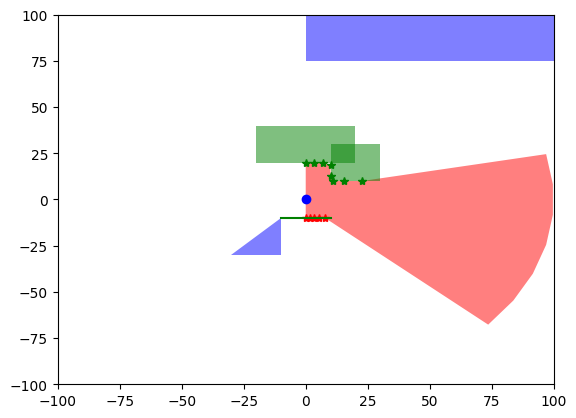

In [5]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiPoint
from shapely.ops import nearest_points, unary_union, split


def ray_casting(observer: Point, fov: float, max_distance: float, structured_obstacles: List[Tuple[Polygon, int]], ray_num: int = 20) -> Tuple[Polygon, List[int], List[int]]:
    """
    光线投射算法
    :param observer: 观察者点
    :param fov: 视场角
    :param max_distance: 最远可视距离
    :param obstacles: 障碍物列表
    :param ray_num: 光线数量
    :return: 可视区域多边形, 障碍物可见性列表
    """

    fov_rad = np.radians(fov)   # 将视场角转换为弧度
    angles = np.linspace(-fov_rad / 2, fov_rad / 2, ray_num)    # 使用360条光线进行采样
    obstacles_union = unary_union([obstacle[0] for obstacle in structured_obstacles])  # 合并所有障碍物
    visible_points = []  # 存储可视边界点
    obstacles_visibility = [0] * len(structured_obstacles)  # 障碍物可见性列表
    visible_area_vertices_type = [0] * ray_num  # 可视区域顶点类型列表
    for v, angle in enumerate(angles):
        # 生成远端点
        far_point = (
            observer.x + max_distance * np.cos(angle),
            observer.y + max_distance * np.sin(angle)
        )

        ray = LineString([observer, far_point])  # 创建射线
        intersections = ray.intersection(obstacles_union)   # 计算射线与所有障碍物的交点
        closest_intersection_distance = max_distance    # 初始化最近交点距离为最大扫描距离

        if not intersections.is_empty:
            # 将交点转换为点列表（支持多种几何类型）
            if 'Point' == intersections.geom_type:
                intersection_points = [intersections]
            elif 'MultiPoint' == intersections.geom_type:
                intersection_points = list(intersections)
            elif 'LineString' == intersections.geom_type:
                intersection_points = [Point(intersections.coords[0])]
            elif 'MultiLineString' == intersections.geom_type:
                intersection_points = [Point(line.coords[0])
                                       for line in intersections.geoms]
            elif 'GeometryCollection' == intersections.geom_type:
                intersection_points = [
                    geom for geom in intersections.geoms if 'Point' == geom.geom_type]

            # 找到最近的交点及其距离
            for intersection_point in intersection_points:
                distance = observer.distance(intersection_point)
                if distance < closest_intersection_distance:
                    closest_intersection_distance = distance
                    nearest_point = (intersection_point.x,
                                     intersection_point.y)

            visible_points.append(nearest_point)    # 添加最近的交点到可视边界点列表

            # 标记最近障碍物为可见
            for i, obstacle in enumerate(structured_obstacles):
                # if obstacles_visibility[i]:
                #     continue
                if LineString([observer, nearest_point]).intersects(obstacle[0]):
                    obstacles_visibility[i] = 1
                    visible_area_vertices_type[v] = obstacle[1]
                    break  # 找到最近障碍物，跳出循环
        else:
            visible_points.append(far_point)    # 如果没有交点，添加远端点

    if fov < 360:
        visible_points.append(observer)  # 添加观察者点

    visible_area = Polygon(visible_points)  # 创建可视区域多边形

    return visible_area, visible_area_vertices_type, obstacles_visibility


# 示例
observer = Point(0, 0)
fov = 180  # 90度视场角
max_distance = 100  # 最远可视距离100个单位
obstacles = [
    Polygon([(-20, 20), (-20, 40), (20, 40), (20, 20)]),
    Polygon([(10, 10), (10, 30), (30, 30), (30, 10)]),
    Polygon([(-10, -10), (-10, -30), (-30, -30)]),
    Polygon([(0, 75), (0, 100), (100, 100), (100, 75)]),
    LineString([(-10, -10), (10, -10)])
]
obstacles_type = [2, 2, 2, 2, 1]    # 障碍物类型列表
structured_obstacles = list(zip(obstacles, obstacles_type))

visible_area, visible_area_vertices_type, obstacles_visibility = ray_casting(
    observer, fov, max_distance, structured_obstacles)

# 绘制可视区域
fig, ax = plt.subplots()
x, y = visible_area.exterior.xy
for i, vertices_type in enumerate(visible_area_vertices_type):
    if vertices_type == 1:
        ax.plot(x[i], y[i], 'r*')
    elif vertices_type == 2:
        ax.plot(x[i], y[i], 'g*')
    
ax.fill(x, y, alpha=0.5, fc='r', ec='none')
ax.plot(*observer.xy, 'bo')  # 观察点
for i, obstacle in enumerate(obstacles):
    if obstacle.geom_type == 'Polygon':
        x, y = obstacle.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='g' if obstacles_visibility[i] else 'b', ec='none')  # 遮挡物体
    elif obstacle.geom_type == 'LineString':
        x, y = obstacle.xy
        ax.plot(x, y, 'g' if obstacles_visibility[i] else 'b')  # 遮挡物体
ax.set_xlim(-max_distance, max_distance)
ax.set_ylim(-max_distance, max_distance)
plt.show()